In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pandas as pd
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [17]:
target = '../Satun-Phang-Nga/forcasting2/'
all_data = []

In [18]:
for file in os.listdir(target):
    file_path = os.path.join(target, file)
    df = pd.read_excel(file_path, usecols=[
        'date', 'uvb', 'tp', 'd2m', 'minTemp', 'meanTemp', 'maxTemp', 'RH', 'WS', 'durationOfDay', 'disease', 'ETo', 'WE'
    ])
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    all_data.append(df)

In [19]:
data_combined = pd.concat(all_data, ignore_index=True)

In [20]:
X = data_combined.drop(['date', 'disease'], axis=1)
y = data_combined['disease']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [24]:
model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.001,
    max_depth=5,
    subsample=0.5,
    colsample_bylevel=0.5,
    colsample_bytree=0.5,
    n_estimators=10000
)

In [25]:
# y_train = y_train.astype(int)
model.fit(X_train_pca, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=None, colsample_bytree=0.5,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.001, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [26]:
y_pred = model.predict(X_test_pca)
y_pred_rounded = np.round(y_pred).astype(int)

In [27]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
n = X_test_pca.shape[0] 
p = X_test_pca.shape[1] 
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [28]:
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {r2_adj:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: -0.0781
Adjusted R²: -0.3091
RMSE: 1.0754
MAE: 0.7608


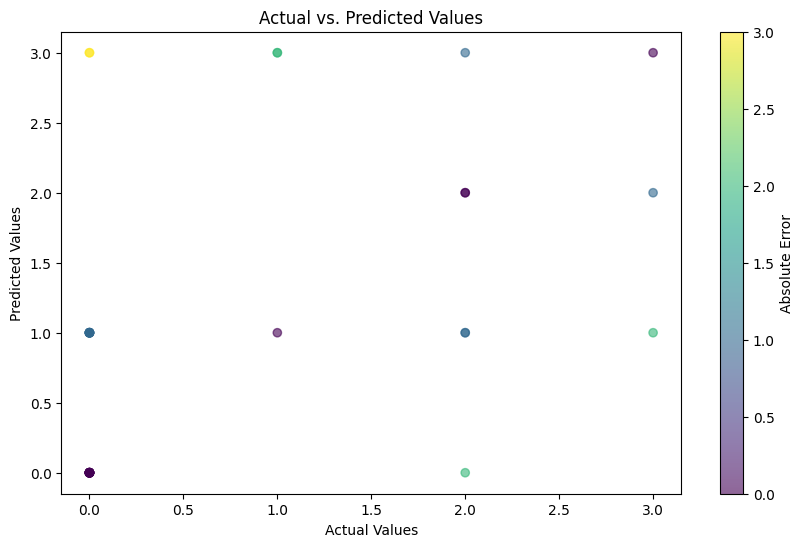

In [29]:
import matplotlib.pyplot as plt

# กำหนดสีให้กับจุดในกราฟ
colors = np.abs(y_pred_rounded - y_test)  # ใช้ค่าความคลาดเคลื่อนเป็นสี

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rounded, c=colors, cmap='viridis', alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.colorbar(label='Absolute Error')  # เพิ่ม colorbar เพื่อแสดงค่าความคลาดเคลื่อน
plt.show()


In [30]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rounded
})
results_df.to_csv('predictions_vs_actual.csv', index=False)
print("Saved predictions and actual values to 'predictions_vs_actual.csv'")

Saved predictions and actual values to 'predictions_vs_actual.csv'
